# Portfolio 3
In this portfolio we are exploring direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit. 

## Approach:
1) Preprocessing
- import the data
- check for nulls
- describe numeric values
- Rename Headers for Readability

2) Encode
- Encoding categorical features
- Run MultinomialNB
- Run GaussianNB

3) Discretize
- Discretization of continuous data
- Run another MultinomialNB

4) RFE


In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt # Matplotlib for additional customization
%matplotlib inline
import seaborn as sns # Seaborn for plotting and styling

## 1) Preprocessing 

### 1a) Import the Data
First: import the data. We are told from the data description that unknown values are filled in as "unknown" so we will convert these to `NaN` when importing. 

In [20]:
bankdf = pd.read_csv("data/bank-additional-full.csv", sep = ';')
print("Shape of data: ", bankdf.shape)
bankdf.head()

Shape of data:  (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


We have 41,188 rows and 21 columns (as expected)

### 1b) Check for Null values
Now check the data for `NaN` as well as other missing values and deal with them appropriately.

In [21]:
#count the number of nulls
print("Number of NaN")
print(bankdf.isnull().sum())

Number of NaN
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


There are no mising/`NaN` values. But we do know there are `"unknown"` values as well as `999` for a majority of contacts as shown below in `pdays`. Next we will check the statistics of the numerical variables

### 1c) Describe numerical values

In [22]:
bankdf.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


From the basic statistics above, we can observe:
- There are no missing values (all have 41,188)
- The average age of customers is 40 and only 25% are under 32. This shows older people are being targeted in this campaign
- Campaign ranges from 1-56 but the majority (75%) are 3 or under. This shows the majority of customer have only been contacted 1-3 times during this campaign however it is worrying that some people have been contacted up to 56 times!
- The majority of data for pdays (days since last contacted) is 999 i.e. client was not previously contacted. This suggests that the majorit of customer are new leads. 
- And for `previous`, the vast majority is 0. This makes sense as we just discovered that the majority of calls are to NEW leads i.e. no previous contact
- There are roughly 5,000 employees. 

In [23]:
print("The number of clients not previously contacted is: ",bankdf.pdays[bankdf['pdays']==999].count(), 
      "which is {:.0f}% of the data".format(bankdf.pdays[bankdf['pdays']==999].count()/bankdf.pdays.count()*100))

The number of clients not previously contacted is:  39673 which is 96% of the data


With such a high number of clients not being contacted before, this variable isn't very relevant. I'll consider making a new feature which is a boolean column indicating true/false if a customer had ever been contacted before. 

We cannot change this number to zero as that would suggest that ZERO days have passed since the client was last contacted i.e. they were contacted multiple times in a day. As below:

In [24]:
bankdf.pdays[bankdf['pdays']==0].count()

15

### 1d) Rename Headers for Readability
Next I will clean up the header names so that they are easier to interpret:

In [25]:
header = list(bankdf)
print(header)

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


In [26]:
header = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact_type', 
          'contact_month', 'contact_day_of_week', 'contact_duration', 'num_contacts_campaign', 
          'days_last_contacted', 'num_contacts_previously', 'prev_outcome', 'emp.var.rate', 'cons.price.idx', 
          'cons.conf.idx', 'euribor3m', 'nr.employed', 
          'y']
bankdf.columns = header
bankdf.head()

,age,job,marital,education,default,housing,loan,contact_type,contact_month,contact_day_of_week,...,num_contacts_campaign,days_last_contacted,num_contacts_previously,prev_outcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## 2) Encoding categorical features
1. convert categorical features to integer codes (refer to http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features). 
2. Then, apply the Gaussian Naive Bayes and 
3. Multinomial Naive Bayes.

### 2a) Convert Categorical&Discrete features to integer codes
Below is a list of our variables/columns and whether they are **continuous** or **discrete**

Variable  |Type
------ | --------
age  | discrete
job  | discrete: label encode
marital | discrete: label encode
education | discrete: label encode
default | discrete: label encode
housing | discrete: label encode
loan | discrete: label encode
contact_type | discrete: label encode
contact_month | discrete: label encode
contact_day_of_week | discrete: label encode
contact_duration | continuous
num_contacts_campaign | discrete
days_last_contacted | discrete
num_contacts_previously | discrete
prev_outcome | discrete: label encode 
emp.var.rate | continuous
cons.price.idx | continuous
cons.conf.idx | continuous
euribor3m | continuous
nr.employed | discrete
y | discrete: label encode | 

In [39]:
#These are the categorical features to be used in the MultinomialNB
discrete_features =  ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
                      'contact_type', 'contact_month', 'contact_day_of_week',
                      'prev_outcome', 'num_contacts_campaign', 
                      'days_last_contacted', 'num_contacts_previously', 'nr.employed']

#These are the categorical features to be used in the MultinomialNB
continuous_features = ['contact_duration','emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m'] 

Below is a function which takes a column as an argument, then encodes that column of the dataframe. I have encoded all the string-categorical variables

In [28]:
#Need to convert strings/cateogories to numeric values
from sklearn import preprocessing
#from sklearn.preprocessing import LabelEncoder

# Create a label (category) encoder object
le = preprocessing.LabelEncoder()

#function to encode categorical data
def encode(column):
    """
    convert a categorical series (column) and conver to numerical
    """
    le.fit(column)
    return le.transform(column)

#encoding of the variables
bankdf.job = encode(bankdf.job)
bankdf.marital = encode(bankdf.marital)
bankdf.education = encode(bankdf.education)
bankdf.default = encode(bankdf.default)
bankdf.housing = encode(bankdf.housing)
bankdf.loan = encode(bankdf.loan)
bankdf.contact_type = encode(bankdf.contact_type)
bankdf.contact_month = encode(bankdf.contact_month)
bankdf.contact_day_of_week = encode(bankdf.contact_day_of_week)
bankdf.prev_outcome = encode(bankdf.prev_outcome)
bankdf.y = encode(bankdf.y)

bankdf.head()

,age,job,marital,education,default,housing,loan,contact_type,contact_month,contact_day_of_week,...,num_contacts_campaign,days_last_contacted,num_contacts_previously,prev_outcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


Next I will split the data into an `X` and `y`

In [29]:
X = bankdf.drop('y', axis=1)  #everything but the class label
y = bankdf['y'] #only the class label

### 2b) MultinomialNB
The multinomial Naive Bayes classifier is suitable for classification with features that are DISCRETE variables (i.e. variables can only take certain numbers). Some of the features are continuous so we cannot expect the best results while they are still continuous. 

I believe the lecturer wants us to include continuous data in this model so that we can see how bad it performs and why you can only use categorical. But since `cons.price.idx` has negative values, it cannot be used, so I will exclude it. 

I will use 70% for training and the rest for testing, and repeat this 10 times with different random seeds [10, 20, 30, 40, 50, 60, 70, 80, 90,100] and report the average ACC (Accuracy) and AUC (Area Under the Curve) on training and test set respectively.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

#lists to hold scores for each random seed
training_ACC = []
test_ACC = []
training_AUC = []
test_AUC = []

X1 = X.drop('emp.var.rate', axis=1)
X1 = X1.drop('cons.price.idx', axis=1)
X1 = X1.drop('cons.conf.idx', axis=1)

#fit model for different random seeds
for i in [10,20,30,40,50,60,70,80,90,100]:
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.30, random_state=i)
    
    #fit the model
    clfM = MultinomialNB(alpha=1)
    clfM.fit(X_train, y_train)
    
    #predict labels
    y_hat_train = clfM.predict(X_train)
    y_hat_test = clfM.predict(X_test)
    
    #calculate ACCuracy
    training_ACC.append(clfM.score(X_train, y_train))
    test_ACC.append(clfM.score(X_test, y_test))
    
    #calculate the AUC using the predicted and true labels
    training_AUC.append(roc_auc_score(y_train, y_hat_train))
    test_AUC.append(roc_auc_score(y_test, y_hat_test))
    
def average(listx):
    """
    take a list and calculate the average
    """
    sum=0
    for i in range(len(listx)):
        sum = sum+listx[i] 
    return sum/len(listx)

#display averages
print("ACC train average: {:.2f}".format(average(training_ACC)))
print("ACC test aveage: {:.2f} ".format(average(test_ACC)))
print("\n")
print("AUC train average: {:.2f}".format(average(training_AUC)))
print("AUC test aveage: {:.2f}".format(average(test_AUC)))

ACC train average: 0.84
ACC test aveage: 0.84 
AUC train average: 0.78
AUC test aveage: 0.78


After fitting the Multinomial Naive Bayes Classifier, it was able to correctly classify 84% of the data (great result!). when used on the test data (data it hasn't seen before), 84% of the data was correctly classified! 

From the AUC, the desired result is 1, we got 0.78 for both training and testing data. 

Next I will run the Gaussian Naive Bayes Classifier which takes only continuous features. Again, I'm not sure why the lecturer wants use to use both continuous and encoded-cateogircal here. I can only assume its so we can see how it doesn't work? 

### 2c) GaussianNB

In [33]:
from sklearn.naive_bayes import GaussianNB

#lists to hold scores for each random seed
training_ACC = []
test_ACC = []
training_AUC = []
test_AUC = []

    #fit model for different random seeds
for i in [10,20,30,40,50,60,70,80,90,100]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=i)

    #fit the model
    clfG = GaussianNB()
    clfG.fit(X_train, y_train)

    #predict labels
    y_hat_train = clfG.predict(X_train)
    y_hat_test = clfG.predict(X_test)
    
    #calculate ACCuracy
    training_ACC.append(clfG.score(X_train, y_train))
    test_ACC.append(clfG.score(X_test, y_test))
    
    #calculate the AUC using the predicted and true labels
    training_AUC.append(roc_auc_score(y_train, y_hat_train))
    test_AUC.append(roc_auc_score(y_test, y_hat_test))

#display averages
print("ACC train average: {:.2f}".format(average(training_ACC)))
print("ACC test aveage: {:.2f} ".format(average(test_ACC)))
print("\n")
print("AUC train average: {:.2f}".format(average(training_AUC)))
print("AUC test average: {:.2f}".format(average(test_AUC)))

ACC train average: 0.85
ACC test aveage: 0.85 


AUC train average: 0.74
AUC test average: 0.74


Shown above, we can see that the Gaussian Naive Bayes Classifier was able to correctly classify 85% correctly for both the training and testing data.

From the AUC, the desired result is 1, we got 0.74 for both training and testing data - great result. 

Lets try to categorise/discretize the continuous features so as to improve the MultinomialNB model. 

## 3) Discretization - Convert Continuous data into Discrete
provides a way to partition continuous features into discrete values (refer to http://scikit-learn.org/stable/modules/preprocessing.html#discretization). Then, apply the Multinomial Naive Bayes to compare the results with those using the ‘Encoding categorical features’ in task 2 and explain the reason.

A reminder of what the continuous features are:

In [40]:
continuous_features

['contact_duration',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m']

And now discretize them

In [41]:
#from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=4, encode='ordinal').fit(X[continuous_features])
X_binned = enc.fit_transform(X[continuous_features])

#X_train_binned, X_test_binned = train_test_split(X, test_size=0.30, random_state=42)
#X_train_binned[continuous_features].head()

discr_df = pd.DataFrame(X_binned, columns = X[continuous_features].columns)
discr_df.head()

,contact_duration,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m
0,2.0,2.0,3.0,3.0,2.0
1,1.0,2.0,3.0,3.0,2.0
2,2.0,2.0,3.0,3.0,2.0
3,1.0,2.0,3.0,3.0,2.0
4,2.0,2.0,3.0,3.0,2.0


Above I have binned the numerical features into categorical bins (n=4) so that these can now be entered into a **Multionomial NB** as they are now discrete.

This also allows us to include for the first time as they previoulsy had negative values. 

Next I will concatenate the discretized data (formerly continuous but now discrete) with the discrete data so that we are working with the original data that is now ALL discretized. 

In [42]:
#dataframe with the discretized features and the encoded categorical features
newdf = pd.concat([discr_df, bankdf[discrete_features]], axis=1)

#check its the same size (41188, 20)
newdf.shape

(41188, 20)

In [43]:
#Train Test Split
X = newdf  #everything but the class label. All are discrete i.e. use MultinomialNB
y = bankdf['y'] #only the class label

#lists to hold scores for each random seed
training_ACC = []
test_ACC = []
training_AUC = []
test_AUC = []

#fit model for different random seeds
for i in [10,20,30,40,50,60,70,80,90,100]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=i)
    
    #fit the model
    clfM = MultinomialNB()
    clfM.fit(X_train, y_train)
    
    #predict labels
    y_hat_train = clfM.predict(X_train)
    y_hat_test = clfM.predict(X_test)
    
    #calculate ACCuracy
    training_ACC.append(clfM.score(X_train, y_train))
    test_ACC.append(clfM.score(X_test, y_test))
    
    #calculate the AUC using the predicted and true labels
    training_AUC.append(roc_auc_score(y_train, y_hat_train))
    test_AUC.append(roc_auc_score(y_test, y_hat_test))

#display averages
print("ACC train average: {:.2f}".format(average(training_ACC)))
print("ACC test aveage: {:.2f} ".format(average(test_ACC)))
print("AUC train average: {:.2f}".format(average(training_AUC)))
print("AUC test average: {:.2f}".format(average(test_AUC)))

ACC train average: 0.90
ACC test aveage: 0.90 
AUC train average: 0.60
AUC test average: 0.59


The Multinomial Naive Bayes classifier is now correctly classifying 90% of the new/unseen data! (90% for both training and testing)

The Area Under the Cruve is at 0.60 and 0.59 out of 1 for the train and test sets respectively. This isn't as good as the GaussianNB (when these features were numeric).

## 4) Feature selection
Using the feature selection you have learned or refer to (http://scikit-learn.org/stable/modules/feature_selection.html) to select the best features. Draw a figure(s) to report the ACC and AUC in the above second task with the different number of best features selected.

Begin a RFE (Recursive Feature Elmination) with cross validation to determine the best number of features to use. 

In [44]:
from sklearn.feature_selection import RFECV
estimator = clfM
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(newdf, y)
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

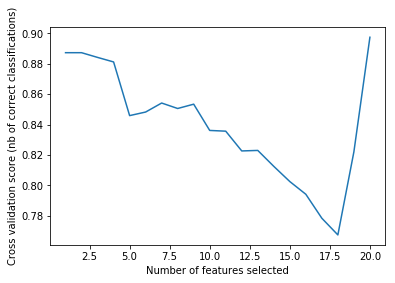

In [45]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

It appears that ALL feature is best  Below is a ranking of the features from best to worst.

In [46]:
from sklearn.feature_selection import RFE
#run the RFE until only 1 feature is left
rfe = RFE(clfM, n_features_to_select = 1)
rfe.fit(newdf, y)

header.pop() #remove class label so left with list of features

#create empty DateFrame to store rankings
rankdf=pd.DataFrame(index=header)

#add ranking array to dataframe (by converting to a series)
rankdf['ranking']=pd.Series(rfe.ranking_, rankdf.index)

#sort values in ascending order
rankdf.sort_values(by='ranking', ascending=True, inplace=True)
rankdf

,ranking
contact_day_of_week,1
days_last_contacted,2
num_contacts_campaign,3
euribor3m,4
default,5
emp.var.rate,6
contact_duration,7
job,8
marital,9
contact_type,10
